In [1]:
import sys
sys.path
sys.path.append("/home/haoqi.whq/llm-inference/LoRA")

from src.model import GPT2Config, GPT2LMModel
import torch
from loralib import PruneLayer
import loralib as lora
import math
import importlib

## Load Data

In [2]:
from torch.utils.data import DataLoader
from src.data_utils import FT_Dataset

train_data = "./data/e2e/train.jsonl"
valid_data = "./data/e2e/valid.jsonl"
train_batch_size = 8
valid_batch_size = 8
seq_len = 512
obj = "clm"
random_seed = 888
label_smooth = 0.1

train_data = FT_Dataset(
    train_data, train_batch_size, seq_len, joint_lm=obj == "jlm"
)

valid_data = FT_Dataset(
    valid_data,
    valid_batch_size,
    seq_len,
)

train_loader = DataLoader(
    train_data,
    batch_size=train_batch_size,
    num_workers=0,
    shuffle=False,
    pin_memory=False,
    drop_last=True,
    # sampler=torch.utils.data.distributed.DistributedSampler(
    #     train_data, seed=random_seed
    # ),
)

valid_loader = DataLoader(
    valid_data,
    batch_size=valid_batch_size,
    num_workers=0,
    shuffle=False,
    pin_memory=False,
    drop_last=False,
    # sampler=torch.utils.data.distributed.DistributedSampler(
    #     valid_data, seed=random_seed
    # ),
)

print(type(train_loader))
# data = train_loader[0]

for i, data in enumerate(valid_loader):
    data = {key: value for key, value in data.items()}
    _input = data["input"]
    _target = data["target"]
    _msk = data["mask"]

    print(_input.shape)
    print(_target.shape)
    print(_msk.shape)
    break

<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])


## Define and Load Model

In [3]:
# medium GPT2
config = GPT2Config(
    n_embd=1024,
    n_layer=24,
    n_head=16,
    lora_attn_dim=4,
    lora_attn_alpha=32,
    lora_dropout=0.1,
    enable_mlp=True,
    enable_wo=True,
    enable_wq=True,
    enable_wk=True,
    enable_wv=True,
    seq_len=512,
    sparsify_activation=True,
    static_sparsity=False
)

lm_net = GPT2LMModel(config)

# summary(lm_net, _input, lm_labels=_target, lm_mask=_msk, label_smooth=label_smooth, depth=6)
# print(lm_net.state_dict())
# transformer.h.0.attn.q_atten.lora_B
# lm_head.decoder.weight
# print("loading model pretrained weight.")
# lm_net.load_lora_weight(
#     "./pretrained_checkpoints/gpt2-medium-pytorch_model.bin", 
#     "./tmp/finetune/qkvom_relu/cp_1e-07/model.cp.lora.26000.pt"
# )
lm_net.load_tuned_total_weight(torch.load("./tmp/sparse/qkvom_relu/model.cp.total.pt"))

O Attention using LoRA: PruneGPTConv1D(
  (lora_dropout): Dropout(p=0.1, inplace=False)
)
MLP using LoRA: PruneGPTConv1D(
  (lora_dropout): Dropout(p=0.1, inplace=False)
), PruneGPTConv1D(
  (lora_dropout): Dropout(p=0.1, inplace=False)
)


In [4]:
# for n, p in lm_net.named_parameters():
#     if "mask" in n:
#         print(n, p)

# for m in lm_net.modules():
#     if isinstance(m, PruneLayer):
#         print(m, m.complexity(), m.lora_scaling, m.keep_flag)

In [5]:
lm_net.cuda()
# lm_net = torch.nn.DataParallel(lm_net)

lora.mark_only_lora_as_trainable(lm_net)
lora.mark_mask_as_not_trainable(lm_net)

for n, p in lm_net.named_parameters():
    if "mask" in n:
        print(n, p)

transformer.h.0.mlp.c_fc.mask_act Parameter containing:
tensor([[ True,  True,  True,  ...,  True, False,  True],
        [ True, False,  True,  ...,  True,  True,  True],
        [False, False,  True,  ..., False, False, False],
        ...,
        [False,  True,  True,  ...,  True,  True,  True],
        [False,  True,  True,  ...,  True,  True,  True],
        [False,  True,  True,  ...,  True,  True,  True]], device='cuda:0')
transformer.h.1.mlp.c_fc.mask_act Parameter containing:
tensor([[ True, False,  True,  ..., False,  True, False],
        [ True, False,  True,  ..., False,  True, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False]], device='cuda:0')
transformer.h.2.mlp.c_fc.mask_act Parameter containing:
tensor([[ True, False,  True,  ..., False,  True, False],
        [ True, 

## Inference

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value
    Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Test Prune LoRA

In [7]:
# lora.prune_lora(lm_net, percent_prune=0.5)

In [8]:
# activations = {}   # 2
# def get_activation(name):   # 3
#     def hook(module, input, output):
#         activations[name] = output.detach()
#     return hook

# for name, layer in lm_net.named_modules():   # 4
#     layer.register_forward_hook(get_activation(name))

In [9]:
# importlib.reload(lora)
lm_net.eval()
avg_lm_loss = AverageMeter()

with torch.no_grad():
    for idx, data in enumerate(train_loader):
        data = {key: value for key, value in data.items()}

        _input = data["input"].cuda()
        _target = data["target"].cuda()
        _msk = data["mask"].cuda()

        _lm_logits, _loss = lm_net(_input, lm_labels=_target, lm_mask=_msk)
        loss = _loss.mean()

        avg_lm_loss.update(loss.item())

        print(f"{idx}-th batch")
        if (idx+1) % 32 == 0:
            print("eval samples:", idx, "loss:", loss.float())
            break

print(avg_lm_loss.avg, math.exp(avg_lm_loss.avg))

Sparsify ratio: 0.8148503303527832
Sparsify ratio: 0.5586986541748047
Sparsify ratio: 0.7510313987731934
Sparsify ratio: 0.8525538444519043
Sparsify ratio: 0.8766379356384277
Sparsify ratio: 0.861048698425293
Sparsify ratio: 0.8600692749023438
Sparsify ratio: 0.8509764671325684
Sparsify ratio: 0.7818155288696289
Sparsify ratio: 0.8464345932006836
Sparsify ratio: 0.8279824256896973
Sparsify ratio: 0.8367819786071777
Sparsify ratio: 0.8093729019165039
Sparsify ratio: 0.808079719543457
Sparsify ratio: 0.8087067604064941
Sparsify ratio: 0.8173165321350098
Sparsify ratio: 0.829442024230957
Sparsify ratio: 0.8053522109985352
Sparsify ratio: 0.8017539978027344
Sparsify ratio: 0.8195943832397461
Sparsify ratio: 0.7671175003051758
Sparsify ratio: 0.7546854019165039
Sparsify ratio: 0.7148146629333496
Sparsify ratio: 0.5978331565856934
0-th batch
Sparsify ratio: 0.8148503303527832
Sparsify ratio: 0.5586986541748047
Sparsify ratio: 0.7510313987731934
Sparsify ratio: 0.8525538444519043
Sparsify rat

/home/haoqi.whq/miniconda3/envs/llm-qd/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Sparsify ratio: 0.8509764671325684
Sparsify ratio: 0.7818155288696289
Sparsify ratio: 0.8464345932006836
Sparsify ratio: 0.8279824256896973
Sparsify ratio: 0.8367819786071777
Sparsify ratio: 0.8093729019165039
Sparsify ratio: 0.808079719543457
Sparsify ratio: 0.8087067604064941
Sparsify ratio: 0.8173165321350098
Sparsify ratio: 0.829442024230957
Sparsify ratio: 0.8053522109985352
Sparsify ratio: 0.8017539978027344
Sparsify ratio: 0.8195943832397461
Sparsify ratio: 0.7671175003051758
Sparsify ratio: 0.7546854019165039
Sparsify ratio: 0.7148146629333496
Sparsify ratio: 0.5978331565856934
1-th batch
Sparsify ratio: 0.8148503303527832
Sparsify ratio: 0.5586986541748047
Sparsify ratio: 0.7510313987731934
Sparsify ratio: 0.8525538444519043
Sparsify ratio: 0.8766379356384277
Sparsify ratio: 0.861048698425293
Sparsify ratio: 0.8600692749023438
Sparsify ratio: 0.8509764671325684
Sparsify ratio: 0.7818155288696289
Sparsify ratio: 0.8464345932006836
Sparsify ratio: 0.8279824256896973
Sparsify rat

In [10]:
import os

base_dir = os.path.join(
    "tmp",
    "sparse",
    "qkvom_relu",
)
model_path = os.path.join(
    base_dir,
    f"model.cp.total.pt",
)
if not os.path.exists(base_dir):
    os.makedirs(base_dir)
print("saving checkpoint", model_path)
torch.save({"model_state_dict": lm_net.state_dict()}, model_path)

saving checkpoint tmp/sparse/qkvom_relu/model.cp.total.pt


## Illustrate distribution

In [11]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, TwoSlopeNorm

n_bin = 16
# vmax = 10
# cmap = mcolors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)

# # Create a custom colormap
# colors = ["white", "black"]
# cmap = ListedColormap(colors)

# cmap = LinearSegmentedColormap.from_list('custom blue', ['blue','lightblue'], N=256)
# cmap.set_over('orange')

# cmap_pos = LinearSegmentedColormap.from_list('custom color', ['white', 'blue'], N=n_bin)

colors = ["black", "orange"]
cmap = ListedColormap(colors)

base_dir = "dist"
n_bins = 20

n_samples = valid_batch_size

def show(idx, component):
    path = os.path.join(base_dir, f"{idx}-{component}-act.pt")
    data = torch.load(path).cpu()
    assert data.shape[0] == n_samples

    # fig = plt.figure()
    fig, axes = plt.subplots(2, 2, figsize=(10, 5))
    axes = axes.flatten()
    for i in range(n_samples):
        # plt.subplot(3, 2, i+1)
        # fig.add_subplot(3, 2, i+1)
        print(f"len: {len(data[i][data[i] > 0])}", data[i][data[i] > 0])
        max_abs = torch.max(torch.abs(data[i]))
        norm = TwoSlopeNorm(vmin=-max_abs, vcenter=0, vmax=max_abs)

        im = axes[i].imshow(data[i], cmap=cmap, aspect='auto', norm=norm)
        # cmap = plt.get_cmap('coolwarm')  # 选择颜色映射
        # vmax = torch.max(data[i])  # 数据的最大绝对值
        # vmin = torch.min(data[i])  # 数据的最大绝对值
        # print(vmax, vmin)
        # plt.imshow(data[i], cmap=cmap, aspect='auto', norm=norm)
    
    # fig.add_subplot(3, 2, 5)
    # plt.colorbar()

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.savefig(f"{base_dir}/{idx}-{component}-sparsity.pdf")


show(1, "o_proj")

AssertionError: 

[[0.8148503303527832, 0.5586986541748047, 0.7510313987731934, 0.8525538444519043, 0.8766379356384277, 0.861048698425293, 0.8600692749023438, 0.8509764671325684, 0.7818155288696289, 0.8464345932006836, 0.8279824256896973, 0.8367819786071777, 0.8093729019165039, 0.808079719543457, 0.8087067604064941, 0.8173165321350098, 0.829442024230957, 0.8053522109985352, 0.8017539978027344, 0.8195943832397461, 0.7671175003051758, 0.7546854019165039, 0.7148146629333496, 0.5978331565856934], [0.8148503303527832, 0.5586986541748047, 0.7510313987731934, 0.8525538444519043, 0.8766379356384277, 0.861048698425293, 0.8600692749023438, 0.8509764671325684, 0.7818155288696289, 0.8464345932006836, 0.8279824256896973, 0.8367819786071777, 0.8093729019165039, 0.808079719543457, 0.8087067604064941, 0.8173165321350098, 0.829442024230957, 0.8053522109985352, 0.8017539978027344, 0.8195943832397461, 0.7671175003051758, 0.7546854019165039, 0.7148146629333496, 0.5978331565856934], [0.8148503303527832, 0.5586986541748047, 

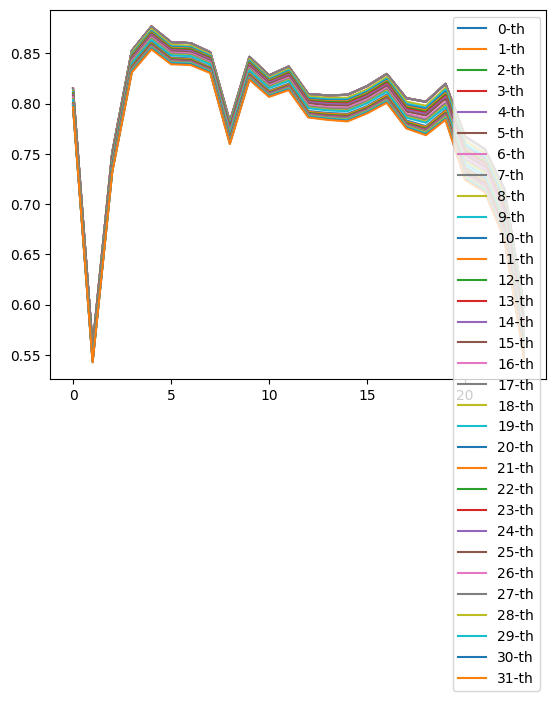

In [3]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

def load_data(path):
    with open(path, "r") as f:
        lines, points = [], []
        for line in f:
            if "-th" in line:
                lines.append(points)
                points = []
            if "ratio" in line:
                value = float(line.split("ratio: ")[-1])
                points.append(value)
    return lines

lines = load_data("test.txt")
print(lines)

plt.figure()
for idx, line in enumerate(lines):
    plt.plot(line, label=f"{idx}-th")
plt.legend()
plt.savefig("fc sparsity by layer.pdf")

In [37]:
import torch
a = torch.arange(15).reshape(3,5).float()
print(a)
xx = torch.tensor([0, 1])
print(a.index_select(-1, xx))
topk, indices = torch.topk(a, 2)
print(indices)
# indices[0] = torch.tensor([])
b = torch.zeros_like(a).scatter(-1, indices, topk)
print(b)

mask = b == 0
print(mask)

print(a)
a[mask] = 0
print(a)

a_s = a.to_sparse_csr()
print(a_s)
print(a_s.coalesce().indices())

a_raw = a_s.to_dense()
print(a_raw)
gelu = torch.nn.GELU()
ss = gelu(a_s.values())

print()
print(a < 5 )
print((a <5) & mask)

tensor([[ 0.,  1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.,  9.],
        [10., 11., 12., 13., 14.]])
tensor([[ 0.,  1.],
        [ 5.,  6.],
        [10., 11.]])
tensor([[4, 3],
        [4, 3],
        [4, 3]])
tensor([[ 0.,  0.,  0.,  3.,  4.],
        [ 0.,  0.,  0.,  8.,  9.],
        [ 0.,  0.,  0., 13., 14.]])
tensor([[ True,  True,  True, False, False],
        [ True,  True,  True, False, False],
        [ True,  True,  True, False, False]])
tensor([[ 0.,  1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.,  9.],
        [10., 11., 12., 13., 14.]])
tensor([[ 0.,  0.,  0.,  3.,  4.],
        [ 0.,  0.,  0.,  8.,  9.],
        [ 0.,  0.,  0., 13., 14.]])
tensor(crow_indices=tensor([0, 2, 4, 6]),
       col_indices=tensor([3, 4, 3, 4, 3, 4]),
       values=tensor([ 3.,  4.,  8.,  9., 13., 14.]), size=(3, 5), nnz=6,
       layout=torch.sparse_csr)


RuntimeError: coalesce expected sparse coordinate tensor layout but got SparseCsr

In [71]:
import torch

# Create a sparse tensor in CSR format
indices = torch.tensor([[0, 1, 1, 2], [0, 1, 2, 2]])
values = torch.tensor([1, 0, 0, 4])
size = torch.Size([3, 3])
sparse_tensor = torch.sparse_coo_tensor(indices, values, size).coalesce()

# a = torch.arange(30).reshape(2, 3,5).float()

# Convert sparse tensor to COO format
csr_tensor =sparse_tensor.to_sparse_csr()
print(csr_tensor)

def fun(x):
    return x + 1

# Modify the values of the COO tensor
# csr_tensor.values()[:] = torch.tensor([1, 2, 6, 4])
# csr_tensor.values().copy_(fun(csr_tensor.values()))
csr_tensor.data = fun(csr_tensor.values())

print(csr_tensor)


tensor(crow_indices=tensor([0, 1, 3, 4]),
       col_indices=tensor([0, 1, 2, 2]),
       values=tensor([1, 0, 0, 4]), size=(3, 3), nnz=4,
       layout=torch.sparse_csr)


RuntimeError: Attempted to call `variable.set_data(tensor)`, but `variable` and `tensor` have incompatible tensor type.

In [73]:
import torch

# Create a sparse CSR tensor
values = torch.tensor([1, 2, 3])
indices = torch.tensor([0, 2, 4])
size = torch.Size([3, 4])
sparse_tensor = torch.sparse_csr_tensor(indices, values, size)

# Create new values for the sparse tensor
new_values = torch.tensor([4, 5, 6])

# Create a new sparse CSR tensor with modified values
modified_sparse_tensor = torch.sparse_csr_tensor(
    sparse_tensor.crow_indices(),
    sparse_tensor.col_indices(),
    new_values,
    size,
    dtype=sparse_tensor.dtype,
    device=sparse_tensor.device,
)

print(modified_sparse_tensor)


tensor(crow_indices=tensor([0, 2, 4]),
       col_indices=tensor([1, 2, 3]),
       values=tensor([4, 5, 6]), size=(3, 4), nnz=3, layout=torch.sparse_csr)


In [29]:
import torch

# 创建一个稀疏张量的indices和values
indices = torch.tensor([[0, 1, 1],
                        [2, 0, 1]])
values = torch.tensor([3, 4, 5])

# 创建目标矩阵
target = torch.zeros((3, 3))

# 使用稀疏张量的indices和values对目标矩阵赋值
sparse_tensor = torch.sparse_coo_tensor(indices, values, size=(3, 3))
target = target.sparse_mask(sparse_tensor).to_dense()

# 输出结果
print("目标矩阵：\n", target)


目标矩阵：
 tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])


2.174860096960275


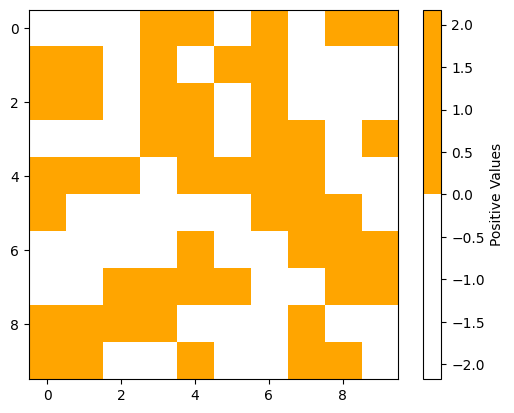

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Generate sample data
data = np.random.randn(10, 10)  # Replace with your data

# Create a custom colormap
# cmap_neg = mcolors.Normalize(vmin=np.min(data), vmax=0)  # Colormap for negative values
print(np.max(data))
norm = mcolors.Normalize(vmin=-np.max(data), vmax=np.max(data))  # Colormap for positive values

colors = ["white", "orange"]
cmap = ListedColormap(colors)

# Plot the image with the custom colormaps
fig, ax = plt.subplots()
im_pos = ax.imshow(data, cmap=cmap, norm=norm)
plt.colorbar(im_pos, ax=ax, label='Positive Values')
# plt.colorbar(im_neg, ax=ax, label='Negative Values')
plt.show()


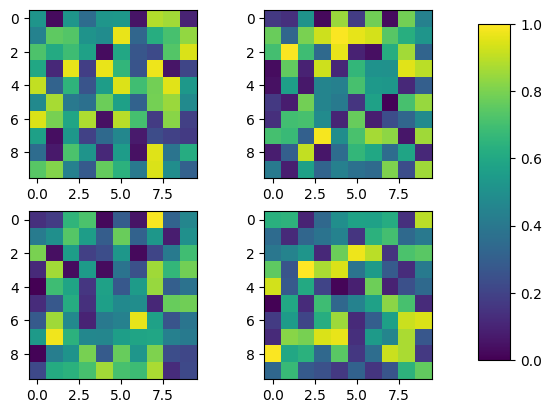

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2)
for ax in axes.flat:
    im = ax.imshow(np.random.random((10,10)), vmin=0, vmax=1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()